## Инициализация

In [1]:
#@title git & pip
!git clone https://github.com/Nehc/gia.git
!pip install -q -r gia/requirements.txt
!apt-get install xvfb > /dev/null
!pip -q install pyvirtualdisplay

Cloning into 'gia'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 196 (delta 74), reused 33 (delta 33), pack-reused 102
Receiving objects: 100% (196/196), 58.34 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (108/108), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.2/527.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [1]:
#@title rand init
import random
import numpy as np
import torch
SEED = 42 #@param {type:"integer"}

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

In [3]:
# @title Environment download { run: "auto", vertical-output: true }
env_type = "simple" # @param ["simple", "cs2_italy"]
gids = {'cs2_italy':'1fEDUcUpgBzrZ_feNRXsagZfFXHZIvoKa',
        'simple':'1fDSxR3PPqoItJ0n1wAfVq--bCj4eNOos'}
!gdown {gids[env_type]}
!mkdir envs
!unzip {env_type}.zip -d envs/{env_type} > /dev/null
!rm {env_type}.zip
!chmod -R 755 envs/{env_type}/{env_type}.x86_64
!chmod -R 755 envs/{env_type}/UnityPlayer.so
!ls -l envs/{env_type}
env_name = f"envs/{env_type}/{env_type}.x86_64"

Downloading...
From: https://drive.google.com/uc?id=1fDSxR3PPqoItJ0n1wAfVq--bCj4eNOos
To: /content/simple.zip
100% 42.5M/42.5M [00:00<00:00, 56.8MB/s]
total 50176
drwxr-xr-x 6 root root     4096 Oct  8 07:29 simple_Data
-rwxr-xr-x 1 root root    15008 Oct  7 21:33 simple.x86_64
-rwxr-xr-x 1 root root 51353848 Oct  7 21:33 UnityPlayer.so


In [4]:
#@title Environment init { vertical-output: true }
#from pyvirtualdisplay import Display
from pyvirtualdisplay.smartdisplay import SmartDisplay as Display
from mlagents_envs.environment import UnityEnvironment

count = 10 #@param {type:"integer"}
disp = Display(); disp.start()
env = UnityEnvironment(file_name=env_name,
                       seed=SEED, side_channels=[],
                       additional_args=['count',f'{count}'])
env.reset()
env_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[env_name]
env_name, spec


('fps_agent?team=0',
 BehaviorSpec(observation_specs=[ObservationSpec(shape=(2,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='S1#Distance'), ObservationSpec(shape=(7,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='S2#Verbal'), ObservationSpec(shape=(112, 112, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='S3#Video')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(7,))))

## Инференс

[array([], shape=(0, 2), dtype=float32),
 array([], shape=(0, 7), dtype=float32),
 array([], shape=(0, 112, 112, 3), dtype=float32)]

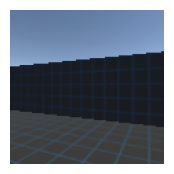

In [5]:
#@title Формат собираемых данных { vertical-output: true }
#@markdown два луча: чисто детектор и вербальный. Визуальные см далее.
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
#@markdown Ray obs: [{one hot tg},{path is clear:bool},{distance(0-1) in max range, 1 if path is clear}]
env.step()
DS, TS = env.get_steps(env_name)
x = DS[0].obs[2]
plt.figure(figsize=(2, 2))
plt.axis("off")
plt.imshow(Image.fromarray((255*x).astype(np.uint8)))
TS.obs


In [ ]:
#@title Сбор датасета
from os import path
import tqdm, torch, numpy as np

from gia.tokenizer import Thinkenizer
from gia.config import Thinker_Conf
from gia.model import Thinker
from gia.solver import Solver

steps = 100 #@param {type:"integer"}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tkn = Thinkenizer(refs_list = ['-','Barrel','Picture','Boxes','Vine box','Market','Gate','Door'],
                  acts_list = ['No','Fwd','Bck','Rgt','Lft','Rsf','Lsf','Goal'],
                  mask_id = 0) #??? НЕ знаю пока - надо ли...

if path.exists("last.ckpt"):
  th = Thinker.load_from_checkpoint("last.ckpt",
       conf = Thinker_Conf(GOAL_IDX=tkn.GOAL_IDX),
       tkn  = tkn).to(device)
else:
  th = Thinker(Thinker_Conf(GOAL_IDX=tkn.GOAL_IDX),
               tkn = tkn).to(device)

s = Solver(th)

datas=[]

for i in tqdm.trange(steps):
  decision_steps, _ = env.get_steps(env_name)
  act, hist = s.Action_on_Decision(decision_steps)
  datas.append(hist)
  env.set_actions(env_name,act)
  env.step()

datas = torch.cat(datas,dim=1)
torch.save(datas, 'dataset.pt')

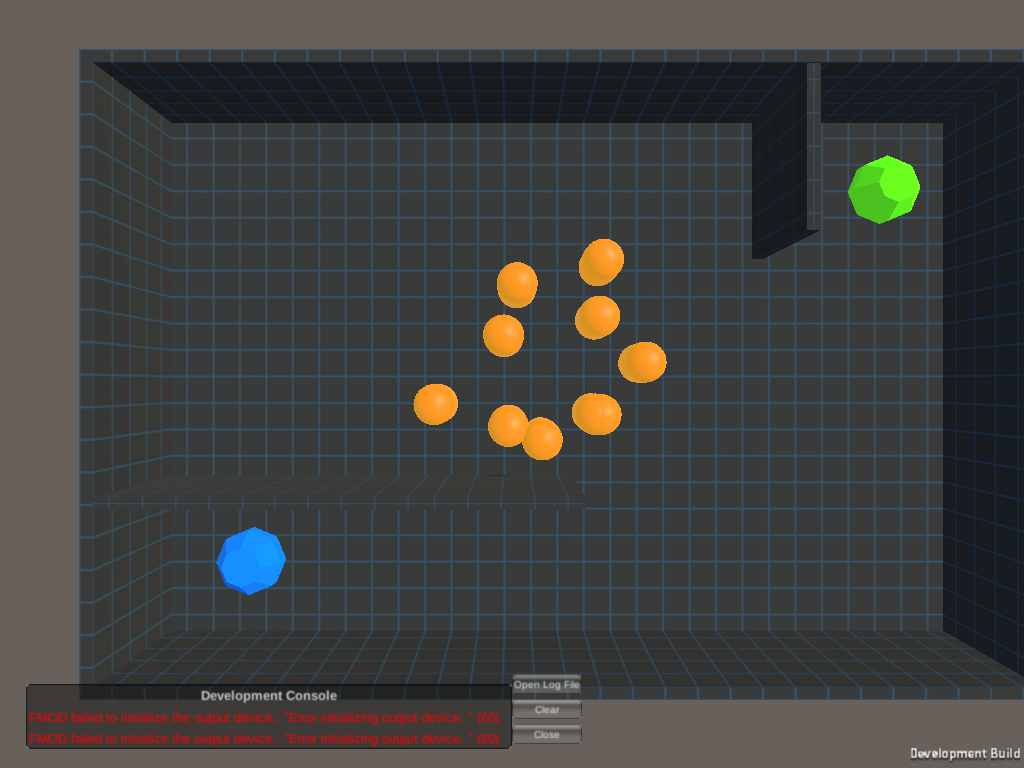

In [12]:
disp.grab()

In [ ]:
datas.shape

torch.Size([10, 100, 51])

In [ ]:
disp.stop(); env.close()

## Train!

In [ ]:
datas = torch.load('dataset.pt')

In [ ]:
from gia.config import Thinker_Conf
from gia.dataset import ThinkDataset
from gia.model import Thinker

cf = Thinker_Conf(GOAL_IDX=tkn.GOAL_IDX)

ds = ThinkDataset(cf, datas, True, use_mask=True, mask_probability=0.9)

th = (Thinker.load_from_checkpoint("last.ckpt",
              cf, ds, tkn) if path.exists("last.ckpt") else
      Thinker(cf, ds, tkn)).to(device)

In [ ]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl

loader = DataLoader(ds, batch_size=10, shuffle=True)
trainer = pl.Trainer(gpus=1, max_epochs=5, precision=16)
trainer.fit(th, loader)

trainer.save_checkpoint("last.ckpt")